# First Graph Convolutional Neural Network
This notebook shows a simple GCN learning using the KrasHras dataset from [Zamora-Resendiz and Crivelli, 2019](https://www.biorxiv.org/content/10.1101/610444v1.full).

In [1]:
import gcn_prot
import torch

import torch.nn.functional as F
from os.path import join, pardir
from random import seed

In [2]:
ROOT_DIR = pardir
seed = 8

## Table of contents

1. [Initialize Data](#Initialize-Data)

## Initialize Data
The data for this experiment is the one used for testing on the [CI of the repository](https://github.com/carrascomj/gcn-prot/blob/master/.travis.yml). Thus, it is already fetched.  

The first step is to calculate the length of the largest protein (in number of aminoacids), since all the proteins will be zero padded to that value. That way, all the inputs fed to the model will have the same length.

In [3]:
largest = gcn_prot.data.get_longest(join(ROOT_DIR, "new_data", "graph"))
print(f"Largets protein has {largest} aminoacids")

Largets protein has 189 aminoacids


However, for this particular dataset, it is known from the aforementioned publication that 185 is enough because the 4 terminal aminoacids were not well determined and would be later discarded by the mask.

In [4]:
largest = 185
data_path = join(ROOT_DIR, "new_data")

The split is performed with 70/10/20 for train/test/valid.  

Note that the generated datasets (custom child classes of `torch.utils.data.Dataset`) doesn't stored the graphs in memory but their paths, generating the graph when accessed by an index.

In [5]:
train, test, valid = gcn_prot.data.get_datasets(
    data_path=data_path,
    nb_nodes=largest,
    task_type="classification",
    nb_classes=2,
    split=[0.7, 0.2, 0.1],
    seed=42,
)

CLASS[COUNTS]:  0 78
CLASS[COUNTS]:  1 158


In [6]:
print(f"Train: {len(train)}\nTest: {len(test)}\nValidation: {len(valid)}")

Train: 164
Test: 48
Validation: 24


In [7]:
type(train)

gcn_prot.data.protien_graph.ProtienGraphDataset

## Define the neural network

Each instance in the dataset retrieves a list of four matrices:
1. **feature matrix**: 29 x 185. This corresponds to the aminoacid type (one-hot encoded vector of length 23), residue depth, residue orientation and 4 features encoding the positional index with a sinusoidal transformation.
2. **coordinates**: 3 x 185. x,y,z coordinates of every aminoacid in the crystal (centered).
3. **mask**: to be applied to the adjacency to discard ill-identified aminoacids.
4. **y**: 2 label, Kras/Hras.  

The transformation of this list to the input of the neural network (feature matrix, adjacency matrix), is performed during training.

In [8]:
model = gcn_prot.models.GCN_simple(
    feats=29,             # features in feature matrix
    hidden=[8, 8],  # number of neurons in convolutional layers (3 in this case)
    label=2,              # features on y
    nb_nodes=largest,     # for last layer
    dropout=0,            # applied in the convolutional layers
    bias=False,           # default
    act=F.relu,           # default
    cuda=True             # required for sparsize and fit_network
).cuda()

Now, instantiate the criterion and the optimizer.

In [9]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss().cuda()

## Train the network

In [10]:
%matplotlib inline

Iteration 2        

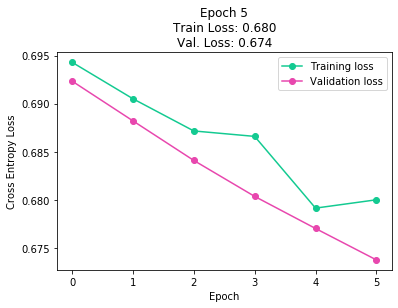

Iteration 2        

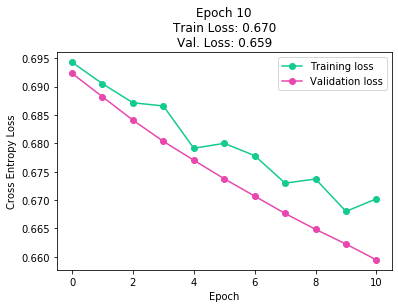

Iteration 2        

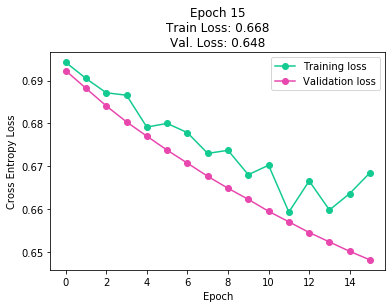

Iteration 2        

In [11]:
save_path = join(ROOT_DIR, "models", "GCN_tiny_weigths.pt")
model_na = gcn_prot.models.fit_network(
    model, train, test, optimizer, criterion,
    batch_size=20,    # a lot of batches per epoch
    epochs=20,
    debug=True,      # will print progress of epochs
    plot_every=5,    # loss plot/epoch
    save=save_path   # best weights (test set) will be saved here
)

Debug with validation.

In [12]:
model.eval()
for batch in torch.utils.data.DataLoader(
        valid, shuffle=True, batch_size=2, drop_last=False
    ):
    print(gcn_prot.models.train.forward_step(batch, model, False))

(tensor([[-0.2259,  0.1046],
        [-0.2259,  0.1046]], device='cuda:0', grad_fn=<AddmmBackward>), tensor([1, 1], device='cuda:0'))
(tensor([[-0.2259,  0.1046],
        [-0.2259,  0.1046]], device='cuda:0', grad_fn=<AddmmBackward>), tensor([0, 1], device='cuda:0'))
(tensor([[-0.2259,  0.1046],
        [-0.2259,  0.1046]], device='cuda:0', grad_fn=<AddmmBackward>), tensor([1, 1], device='cuda:0'))
(tensor([[-0.2259,  0.1046],
        [-0.2259,  0.1046]], device='cuda:0', grad_fn=<AddmmBackward>), tensor([0, 1], device='cuda:0'))
(tensor([[-0.2259,  0.1046],
        [-0.2259,  0.1046]], device='cuda:0', grad_fn=<AddmmBackward>), tensor([1, 0], device='cuda:0'))
(tensor([[-0.2259,  0.1046],
        [-0.2259,  0.1046]], device='cuda:0', grad_fn=<AddmmBackward>), tensor([1, 0], device='cuda:0'))
(tensor([[-0.2259,  0.1046],
        [-0.2259,  0.1046]], device='cuda:0', grad_fn=<AddmmBackward>), tensor([1, 1], device='cuda:0'))
(tensor([[-0.2259,  0.1046],
        [-0.2259,  0.1046]], devi